In [2]:
from os import environ
environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/home/valsp/miniconda3/envs/tf/lib"


In [3]:
import numpy as np
import pickle
from tensorflow import reduce_mean
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, Dense, Flatten, LSTM, Masking
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from model_helper import *
from pathlib import Path
from datetime import datetime


2023-04-23 12:36:16.476918: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 1. Load in dataset

In [4]:
cwd = Path().cwd()

In [5]:
with open(cwd.parent / "preprocessing" / "training_seq_n_12_rmrp0", "rb") as f:
    train_data = pickle.load(f)
with open(cwd.parent / "preprocessing" / "dev_seq_n_12_rmrp0", "rb") as f:
    val_data = pickle.load(f)
with open(cwd.parent / "preprocessing" / "test_seq_n_12_rmrp0", "rb") as f:
    test_data = pickle.load(f)

In [6]:
X_train = np.array(train_data["X"])
print(f"X_train shape: {X_train.shape}")
Y_train = np.array(train_data["Y"])
print(f"Y_train shape: {Y_train.shape}")
X_val = np.array(val_data["X"])
print(f"X_val shape: {X_val.shape}")
Y_val = np.array(val_data["Y"])
print(f"Y_val shape: {Y_val.shape}")
X_test = np.array(test_data["X"])
print(f"X_test shape: {X_test.shape}")
Y_test = np.array(test_data["Y"])
print(f"Y_test shape: {Y_test.shape}")

X_train shape: (20157, 12, 22)
Y_train shape: (20157,)
X_val shape: (2442, 12, 22)
Y_val shape: (2442,)
X_test shape: (2497, 12, 22)
Y_test shape: (2497,)


In [17]:
for i in range(len(Y_train)):
    if Y_train[i] + 4 == 8:
        break
print(i)

20


In [13]:
Y_train[242]

2.0

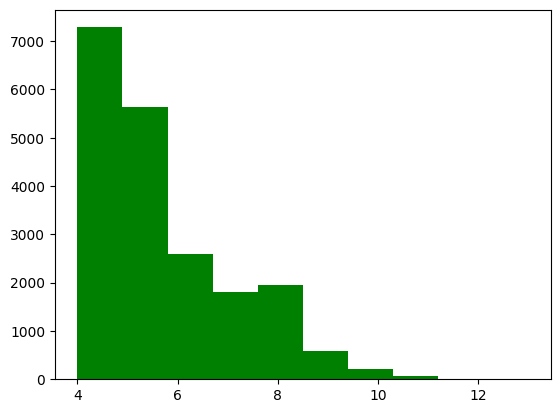

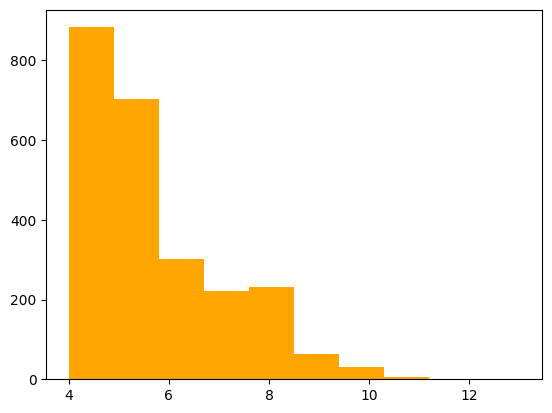

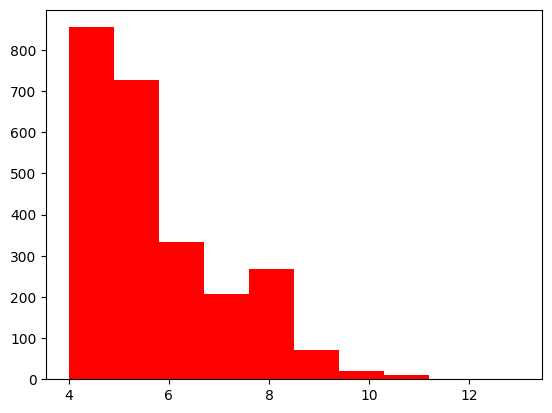

In [41]:
plt.hist(Y_train+4, color="green")
plt.show()
plt.hist(Y_val+4, color="orange")
plt.show()

plt.hist(Y_test+4, color="red")
plt.show()


## 2. Define GradeNet Model

In [29]:
def GradeNet(n_holds=12):
    """Creates a keras model for the GradeNet architecture

    Returns:
        Model: GradeNet model
    """
    inputs = Input(shape=(n_holds, 22))
    mask = Masking(mask_value=0.0).compute_mask(inputs)
    lstm0 = LSTM(
        20,
        activation="tanh",
        input_shape=(n_holds, 22),
        kernel_initializer="glorot_normal",
        return_sequences="True",
    )(inputs, mask=mask)
    dense1 = Dense(100, activation="relu", kernel_initializer="glorot_normal")(lstm0)
    dense2 = Dense(80, activation="relu", kernel_initializer="glorot_normal")(dense1)
    dense3 = Dense(75, activation="relu", kernel_initializer="glorot_normal")(dense2)
    dense4 = Dense(50, activation="relu", kernel_initializer="glorot_normal")(dense3)
    dense5 = Dense(20, activation="relu", kernel_initializer="glorot_normal")(dense4)
    dense6 = Dense(10, activation="relu", kernel_initializer="glorot_normal")(dense5)
    flat = Flatten()(dense6)
    softmax2 = Dense(10, activation="softmax", name="softmax2")(flat)
    lstm1 = LSTM(
        20, activation="tanh", kernel_initializer="glorot_normal", return_sequences=True
    )(dense6)
    lstm2 = LSTM(20, activation="tanh", kernel_initializer="glorot_normal")(lstm1)
    dense7 = Dense(15, activation="relu", kernel_initializer="glorot_normal")(lstm2)
    dense8 = Dense(15, activation="relu", kernel_initializer="glorot_normal")(dense7)
    # softmax3 = Dense(10, activation="softmax", name="softmax3")(dense8)
    out = Dense(1, name="out")(dense8)

    # return Model(inputs=[inputs], outputs=[softmax3, softmax2])
    return Model(inputs=[inputs], outputs=[out])

In [33]:
from tensorflow.keras.losses import MeanSquaredError 

In [34]:
# TODO: re-enable custom loss, trying to get it to equal sum of intermediate and final loss
# def custom_loss(y_true, y_pred):
#     """Custom loss function with averages the final and interdiate (prior to lstm) losses"""
#     # TODO: what is the distinct benefit of intermediate loss for our use model
#     # Improved optimization: By including an additional cross-entropy loss at an intermediate layer, we provide the network with more information about the error signal and can help to prevent vanishing gradients, which can occur in deep networks. This can lead to more stable and efficient optimization during training.
#     # Better representation learning: Cross-entropy loss at an intermediate layer can encourage the network to learn better representations of the input data, which can improve the accuracy of the final predictions. This is because the intermediate layer may capture more complex and abstract features of the input data, which can be useful for discriminating between different classes.
#     # Regularization: Including an intermediate cross-entropy loss can also act as a form of regularization, by encouraging the network to learn representations that are more useful for classification. This can prevent overfitting and improve the generalization performance of the network.

#     # sparse cross entropy is used as y_true is encoded as integers not one-hot vectors
#     # returns cross entropy for each prediction
#     intermediate_loss = SparseCategoricalCrossentropy()(y_true, intermediate)
#     final_loss = SparseCategoricalCrossentropy()(y_true, y_pred)
#     # add the cross entropies and average over the predictions
#     return reduce_mean(intermediate_loss + final_loss)

model = GradeNet()
model.compile(
    optimizer="adam",
    # loss={
    #     "softmax3": "sparse_categorical_crossentropy",
    #     "softmax2": "sparse_categorical_crossentropy",
    # },
    loss = MeanSquaredError(),
    # metrics=[RootMeanSquaredError(), ],
)

## 2-1. Training of GradeNet
### To load pretrained weights, please skip to 2-2.

In [23]:
# tensorboard callback
log_dir = cwd / "logs" / "GradeNet" / datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# checkpoint callback
checkpoint_path = (
    cwd / "checkpoints" / "GradeNet" / "epoch{epoch:02d}-loss{val_loss:.2f}.h5"
)
cp_callback = ModelCheckpoint(
    filepath=str(checkpoint_path),
    save_weights_only=True,
    save_best_only=True,
    verbose=1,
)

In [35]:
# TODO: where do the class weights come from, can we load them from a config?
# old {0: 1, 1: 1, 2: 2, 3: 2, 4: 1, 5: 4, 6: 2, 7: 4, 8: 8, 9: 8},
# new {0: 1, 1: 1, 2: 2, 3: 4, 4: 1, 5: 4, 6: 8, 7: 8, 8: 8, 9: 8},

# grade_weights = {0: 1, 1: 1, 2: 2, 3: 4, 4: 1, 5: 4, 6: 8, 7: 8, 8: 8, 9: 8}
history = model.fit(
    X_train,
    Y_train,
    validation_data=(X_val, Y_val),
    epochs=30,
    batch_size=256,
    # class_weight=grade_weights,
    callbacks=[tensorboard_callback, cp_callback],
)
# model.load_weights('GradeNet.h5')

Epoch 1/100
79/79 [==============================] - ETA: 0s - loss: 2.6524
Epoch 1: val_loss did not improve from 1.12680
79/79 [==============================] - 26s 128ms/step - loss: 2.6524 - val_loss: 1.4661
Epoch 2/100
79/79 [==============================] - ETA: 0s - loss: 1.2181
Epoch 2: val_loss improved from 1.12680 to 1.06942, saving model to /mnt/c/Users/valsp/source/repos/MoonBoardRNN/model/checkpoints/GradeNet/epoch02-loss1.07.h5
79/79 [==============================] - 6s 69ms/step - loss: 1.2181 - val_loss: 1.0694
Epoch 3/100
79/79 [==============================] - ETA: 0s - loss: 1.0413
Epoch 3: val_loss improved from 1.06942 to 1.01694, saving model to /mnt/c/Users/valsp/source/repos/MoonBoardRNN/model/checkpoints/GradeNet/epoch03-loss1.02.h5
79/79 [==============================] - 6s 74ms/step - loss: 1.0413 - val_loss: 1.0169
Epoch 4/100
79/79 [==============================] - ETA: 0s - loss: 0.9912
Epoch 4: val_loss improved from 1.01694 to 0.99152, saving mode

In [36]:
import model_helper
from importlib import reload
reload(model_helper)
from model_helper import plot_history

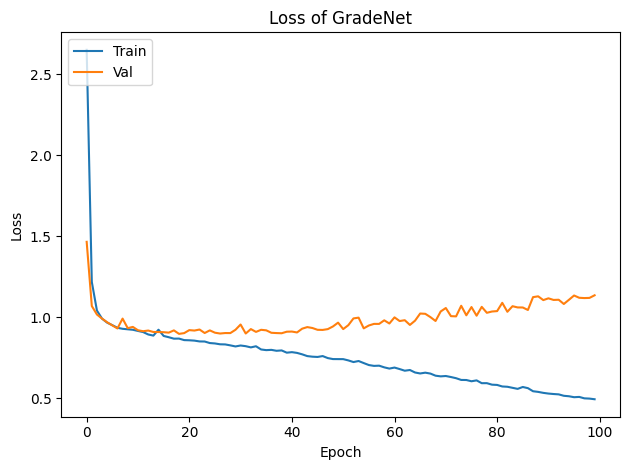

In [37]:
try:
    history_path = cwd / "GradeNet_train_history"
    plot_history(history, "GradeNet")
    save_pickle(history, history_path)
except NameError:
    plot_tb_history(log_dir, "GradeNet")

In [38]:
# load best checkpoint
best_cp = sorted(checkpoint_path.parent.glob("*.h5"), key=lambda p: float(p.stem.split("-")[1][4:]))[0]
best_cp

PosixPath('/mnt/c/Users/valsp/source/repos/MoonBoardRNN/model/checkpoints/GradeNet/epoch17-loss0.90.h5')

In [39]:
model.load_weights(best_cp)

## 2.2 - Saving the model

In [40]:
model.save('GradeNet', include_optimizer=False)

INFO:tensorflow:Assets written to: GradeNet/assets


INFO:tensorflow:Assets written to: GradeNet/assets
